In [2]:
import numpy as np
import os
import pickle
import pandas as pd
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from numpy import linalg as LA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


# Data Preprocessing

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6

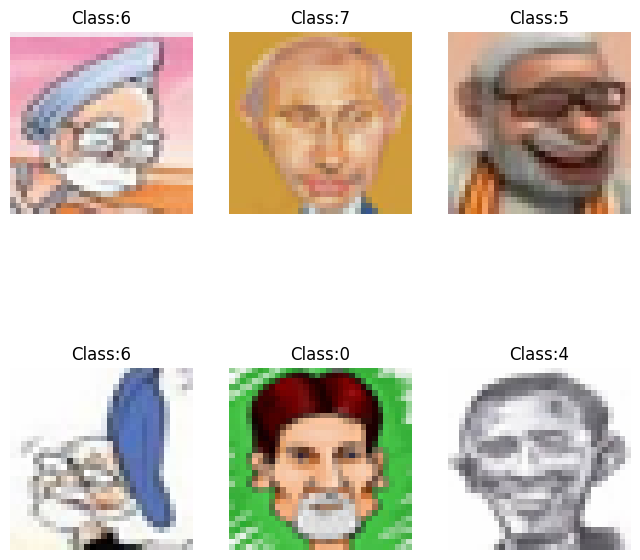

In [3]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list


dirpath = 'PCA_DATA/IIIT-CFW/IIIT-CFW'
X,y = load_data(dirpath)
Z = X.reshape(X.shape[0], -1)
print(y)
print(Z.shape)
# print(Z[0][31])
# [[[a,b,c]....32 times]...32 times]
N,H,W = X.shape[0:3]
# print(N,H,W)
C = 1 if opt['is_grayscale'] else X.shape[3]
ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

Implementation of Principle Component Analysis

(3072, 672)
672
239.52801368309466
[0.33621194 0.41963403 0.47370082 ... 1.         1.         1.        ]


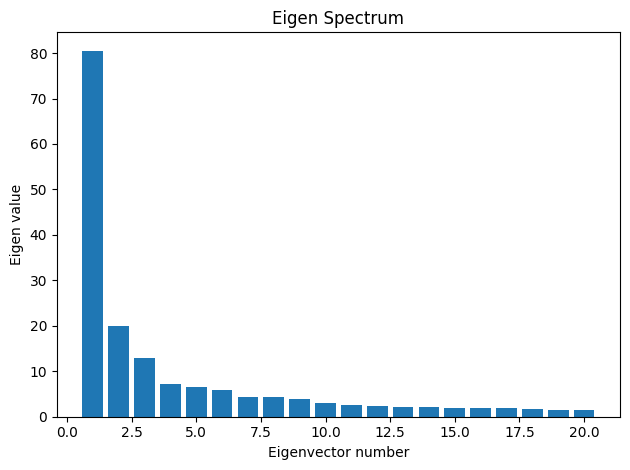

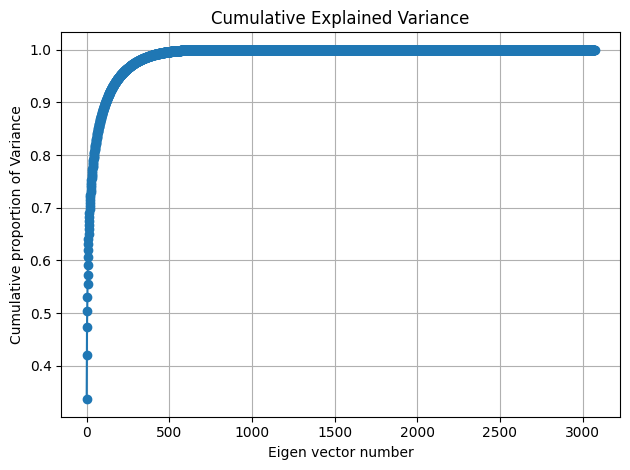

In [4]:
# class sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

# Assume that we start with a data set that is represented in terms of an m × n matrix, X ; where the n columns are the samples (e.g. observations) and the m rows are the variables
class PCA:
    def __init__(self,n_components_=None,components_ = None,mean_=None,explained_variance_ratio_=None):
        self.n_components_ = n_components_ # The estimated number of components
        self.components_ = components_ # ndarray of shape (n_components, n_features)
        self.mean_ = mean_ # ndarray of shape (n_features,) Per-feature empirical mean, estimated from the training set.
        self.explained_variance_ratio_ = explained_variance_ratio_
    def fit(self,X):
        # Shape of X is (672,32,32,3) , Now  we convert it into 3072*672 matrix
        num_samples = X.shape[0]
        T = (X.reshape(num_samples,-1)).T
        print(T.shape)
        mean = np.mean(T,axis=1) # calculates mean along columns in a single row
        self.mean_ = mean
        # Suppose we have a vector of n discrete measurements, r̃ = (r̃1 ,r̃2 , . . . , r̃n), with mean µr .If we subtract the mean from each of the measurements, then we obtain a translated set of measurements r = (r1 ,r2 , . . . , rn), that has zero mean.
        X_centered = T-mean.reshape(-1,1) 
        Z = X_centered.T/np.sqrt(num_samples-1)
        # Covariance can be thought of as a measure of how much two variables change together. Variance is thus a special case of covariance, when the the two variables are identical.
        C = (Z.T@Z)
        print(num_samples)
        eigenvalues, eigenvectors = LA.eigh(C) # Return the eigenvalues and eigenvectors of a complex Hermitian (conjugate symmetric) or a real symmetric matrix , matrix deals with XX^T
        sorted_indices = np.argsort(-eigenvalues)
        self.eigen_values = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        self.components_ = eigenvectors
        total_variance = np.sum(self.eigen_values)
        print(total_variance)
        self.explained_variance_ratio_ = np.cumsum(self.eigen_values/total_variance)
    def transform(self,X):
        if self.mean_ is None:
            raise ValueError("Mean is not Defined.")
        if self.eigen_vectors is None:
            raise ValueError("Eigen Vectors are Not Defined.")
        num_samples = X.shape[0]
        num_samples = X.shape[0]
        T = (X.reshape(num_samples,-1)).T
        print(T.shape)
        mean = np.mean(T,axis=1) # calculates mean along columns in a single row
        # Suppose we have a vector of n discrete measurements, r̃ = (r̃1 ,r̃2 , . . . , r̃n), with mean µr .If we subtract the mean from each of the measurements, then we obtain a translated set of measurements r = (r1 ,r2 , . . . , rn), that has zero mean.
        X_centered = T-mean.reshape(-1,1) 
        reduced_data = self.eigen_vectors[:, :self.n_components].T @ X_centered
        return reduced_data

    def eigen_spectrum(self,num_components = None):
        # print(self.eigen_values)
        print(self.explained_variance_ratio_)
        if num_components is None:
            num_components = self.n_components_
        top_eigen_values = self.eigen_values[:num_components]
        plt.bar(range(1,1+num_components),top_eigen_values)
        plt.xlabel('Eigenvector number')
        plt.ylabel('Eigen value')
        plt.title('Eigen Spectrum')
        plt.tight_layout()
        plt.show()
    def plot_cumulative_variance(self):
        plt.plot(np.arange(1, len(self.explained_variance_ratio_) + 1), self.explained_variance_ratio_, marker='o')
        plt.xlabel('Eigen vector number')
        plt.ylabel('Cumulative proportion of Variance')
        plt.title('Cumulative Explained Variance')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
n_components = 20
pca = PCA(20)
pca.fit(X)
pca.eigen_spectrum()
pca.plot_cumulative_variance()

In [5]:
data = np.load('data.npy', allow_pickle=True)
# game_id , resnet(1 x 1024) , vit (1 x 512) , label_name , guess time
resnet = np.array([res[0] for res in np.array(data[:,1])])
vit = np.array([v[0] for v in np.array(data[:,2])])
print(vit.shape)
pca = PCA(200)
pca.fit(vit)
transformed_vit = pca.transform(vit)
data_labels = np.array(data[:, 3])
X_train, X_test, y_train, y_test = train_test_split(transformed_vit,data_labels,test_size=0.2, random_state=42) 
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)





(1500, 512)
